In [1]:
###importing all dependancies
import numpy as np
import pandas as pd
from pathlib import Path
import requests
import time
from dotenv import load_dotenv
import os
import pandas as pd
import json
import datetime as dt
from prophet import Prophet
import matplotlib.pyplot

In [2]:
#reading in the DF
df=pd.read_csv(Path('../resources/Crime_Data_from_2020_to_Present.csv'))

In [3]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


In [4]:
options = [110, 113, 121, 122, 815, 820, 821, 210, 220, 230, 231, 235, 236, 250, 251, 761, 926, 435, 436, 437, 622, 623, 624, 625, 626, 627, 647, 763, 928, 930]
df['is_violent'] = df['Crm Cd'].isin(options)

In [5]:
#df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%Y-%m-%d')
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')

In [24]:
df['Year'] = df['DATE OCC'].dt.year

NameError: name 'plt' is not defined

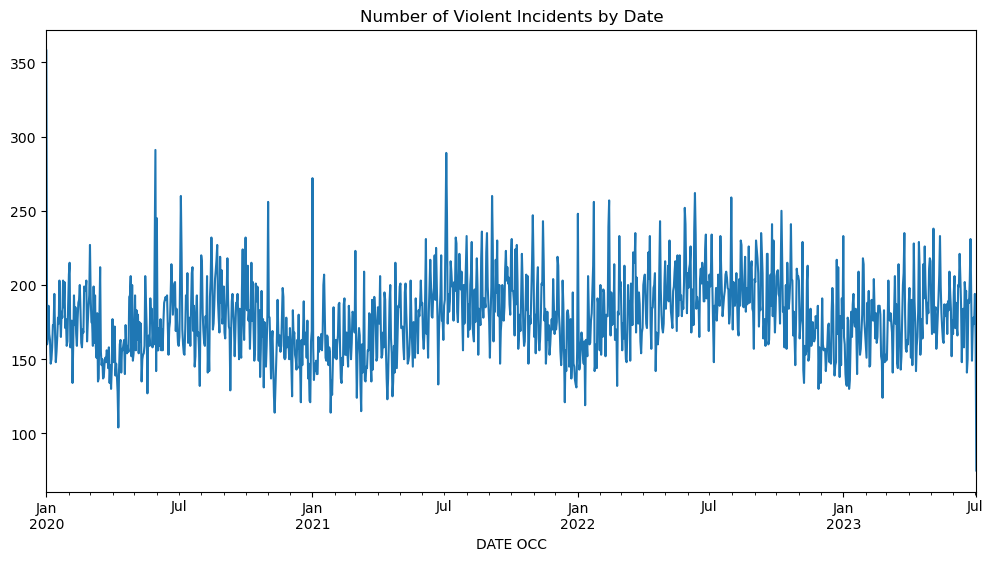

In [28]:
#create a violent and nonviolent df
df_violent = df[df['is_violent'] == True].copy()

violent_counts = df_violent.groupby('DATE OCC').size()

violent_counts.plot(kind='line', figsize=(12, 6), title='Number of Violent Incidents by Date')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.show()

NameError: name 'plt' is not defined

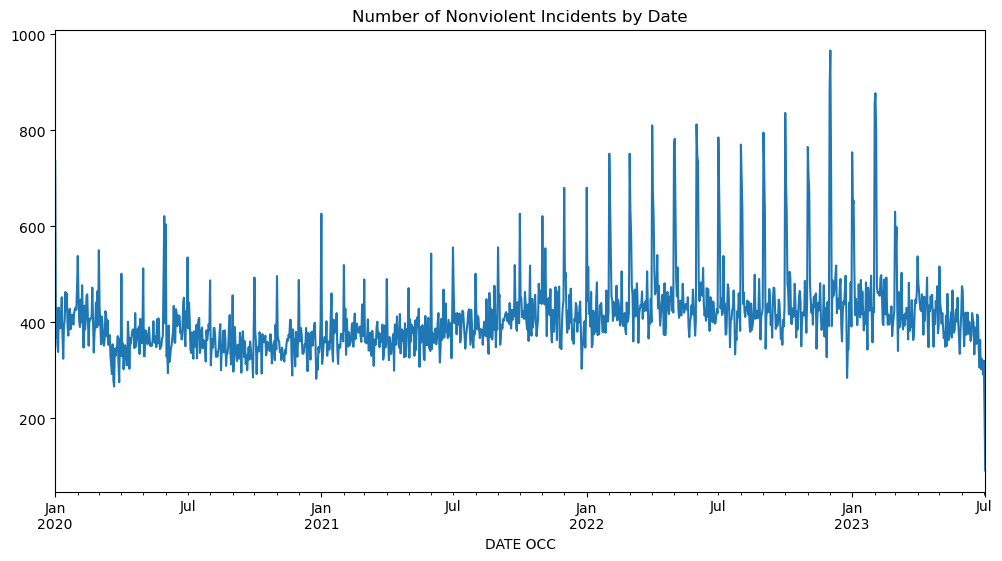

In [13]:
df_nonviolent = df[df['is_violent'] == False].copy()

nonviolent_counts = df_nonviolent.groupby('DATE OCC').size()

nonviolent_counts.plot(kind='line', figsize=(12, 6), title='Number of Nonviolent Incidents by Date')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.show()

In [ ]:
#the most popular URL in history
#⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️
#⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️
#⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️
#⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️
#⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️
#⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️
#⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️
#⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️
#⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️
#⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️
#⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬜️
#⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬜️
#⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️
#⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️
#⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️
#⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️
#⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️
#⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️
#⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️
#⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬛️)